In [54]:
!pip install qiskit==1.1
!pip install qiskit_aer
!pip install pylatexenc

In [55]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer

import matplotlib
import numpy as np

In [56]:
def prepare_state_register(qc, assign, cost, flag, superflag):
    # Create |ψ₀⟩, a uniform superposition over all UE→AP assignments (Fig. 2 Preparation).
    qc.reset(assign)
    qc.reset(cost)
    qc.reset(flag)
    qc.reset(superflag)
    qc.h(assign)
    qc.x(superflag)
    qc.h(superflag)
    qc.barrier(assign)

In [57]:
def oracle_objective_phase(qc, assign, cost, link_cost_matrix, alpha):
    # Encode the weight matrix into controlled phase rotations using θ = arccos(sqrt(w_norm)) (Fig. 2 Oracle – Objective).
    max_w = float(np.max(link_cost_matrix))

    qc.barrier(*assign, *cost)
    N, M = link_cost_matrix.shape

    for i in range(N):
        for j in range(M):
            w = link_cost_matrix[i, j]
            w_norm = w / max_w
            theta = np.arccos(np.sqrt(w_norm))

            if j == 0:
                qc.x(assign[i])
            qc.cry(theta, assign[i], cost[i])
            if j == 0:
                qc.x(assign[i])
    qc.barrier(*assign, *cost)

In [58]:
def inverse_objective_phase(qc, assign, cost, link_cost_matrix, alpha):
    # Undo the phase kick applied by oracle_objective_phase. Required inside the amplitude‑amplification loop.
    max_w = float(np.max(link_cost_matrix))

    qc.barrier(*assign, *cost)
    N, M = link_cost_matrix.shape

    for i in reversed(range(N)):
        for j in reversed(range(M)):
            w = link_cost_matrix[i, j]
            w_norm = w / max_w
            theta = np.arccos(np.sqrt(w_norm))

            if j == 0:
                qc.x(assign[i])
            qc.cry(-theta, assign[i], cost[i])
            if j == 0:
                qc.x(assign[i])

In [59]:
def oracle_access_limit(qc, assign, flag, pattern):
    # Phase‑flip states where any AP exceeds the allowed UE load (Fig. 2 Oracle – Access limit). The circuit topology is kept identical to the original implementation.
    zero_idxs = [i for i,b in enumerate(pattern) if b==0]
    for i in zero_idxs:
        qc.x(assign[i])

    qc.mcx(list(assign), flag[0])

    for i in zero_idxs:
        qc.x(assign[i])

    qc.barrier(*assign, flag[0])

In [60]:
def apply_superflag(qc, assign, cost: QuantumRegister, flag: QuantumRegister, superflag: QuantumRegister):
    qc.barrier(*cost, flag[0], superflag[0])
    controls = list(cost[:] ) + [flag[0]]
    qc.x(cost)
    qc.mcx(controls, superflag[0])
    qc.x(cost)

    qc.barrier(*assign, *cost, flag[0], superflag[0])

In [61]:
def apply_oracle(
    qc,
    assign: QuantumRegister,
    cost: QuantumRegister,
    flag: QuantumRegister,
    superflag: QuantumRegister,
    link_cost_matrix: np.ndarray,
    alpha: float,
    patterns: list[list[int]]
):
    qc.barrier(*assign, *cost)
    oracle_objective_phase(qc, assign, cost, link_cost_matrix, alpha)
    qc.barrier(*assign, *cost)

    for pat in patterns:
        oracle_access_limit(qc, assign, flag, pat)

    apply_superflag(qc, assign, cost, flag, superflag)

    for pat in reversed(patterns):
        oracle_access_limit(qc, assign, flag, pat)

    qc.barrier(*assign, *cost)
    inverse_objective_phase(qc, assign, cost, link_cost_matrix, alpha)
    qc.barrier(*assign, *cost)

In [62]:
def apply_diffusion(qc, assign):
    # Diffusion operator about the uniform superposition (core of amplitude‑amplification).
    qc.h(assign)
    qc.x(assign)
    qc.h(assign[-1])
    qc.mcx(assign[:-1], assign[-1])
    qc.h(assign[-1])
    qc.x(assign)
    qc.h(assign)
    qc.barrier(*assign)

In [63]:
def amplify_amplitude(
    # Repeatedly apply oracle ⊕ diffusion to amplify the amplitude of feasible low‑power states (Fig. 2 Diffusion + Amplification).
    N, M,
    link_cost_matrix, patterns,
    alpha=1.0, iterations=1
):
    assign    = QuantumRegister(N, name="q_assign")
    cost      = QuantumRegister(N, name="q_cost")
    flag      = QuantumRegister(1, name="q_flag")
    superflag = QuantumRegister(1, name="q_superflag")
    cl        = ClassicalRegister(N, name="c")

    qc = QuantumCircuit(assign, cost, flag, superflag, cl,
                        name="GroverWithSuperflag")

    prepare_state_register(qc, assign, cost, flag, superflag)

    for _ in range(iterations):
        apply_oracle(
            qc,
            assign,
            cost,
            flag,
            superflag,
            link_cost_matrix,
            alpha,
            patterns
        )
        apply_diffusion(qc, assign)

    qc.barrier(*assign)
    qc.measure(assign, cl)
    return qc

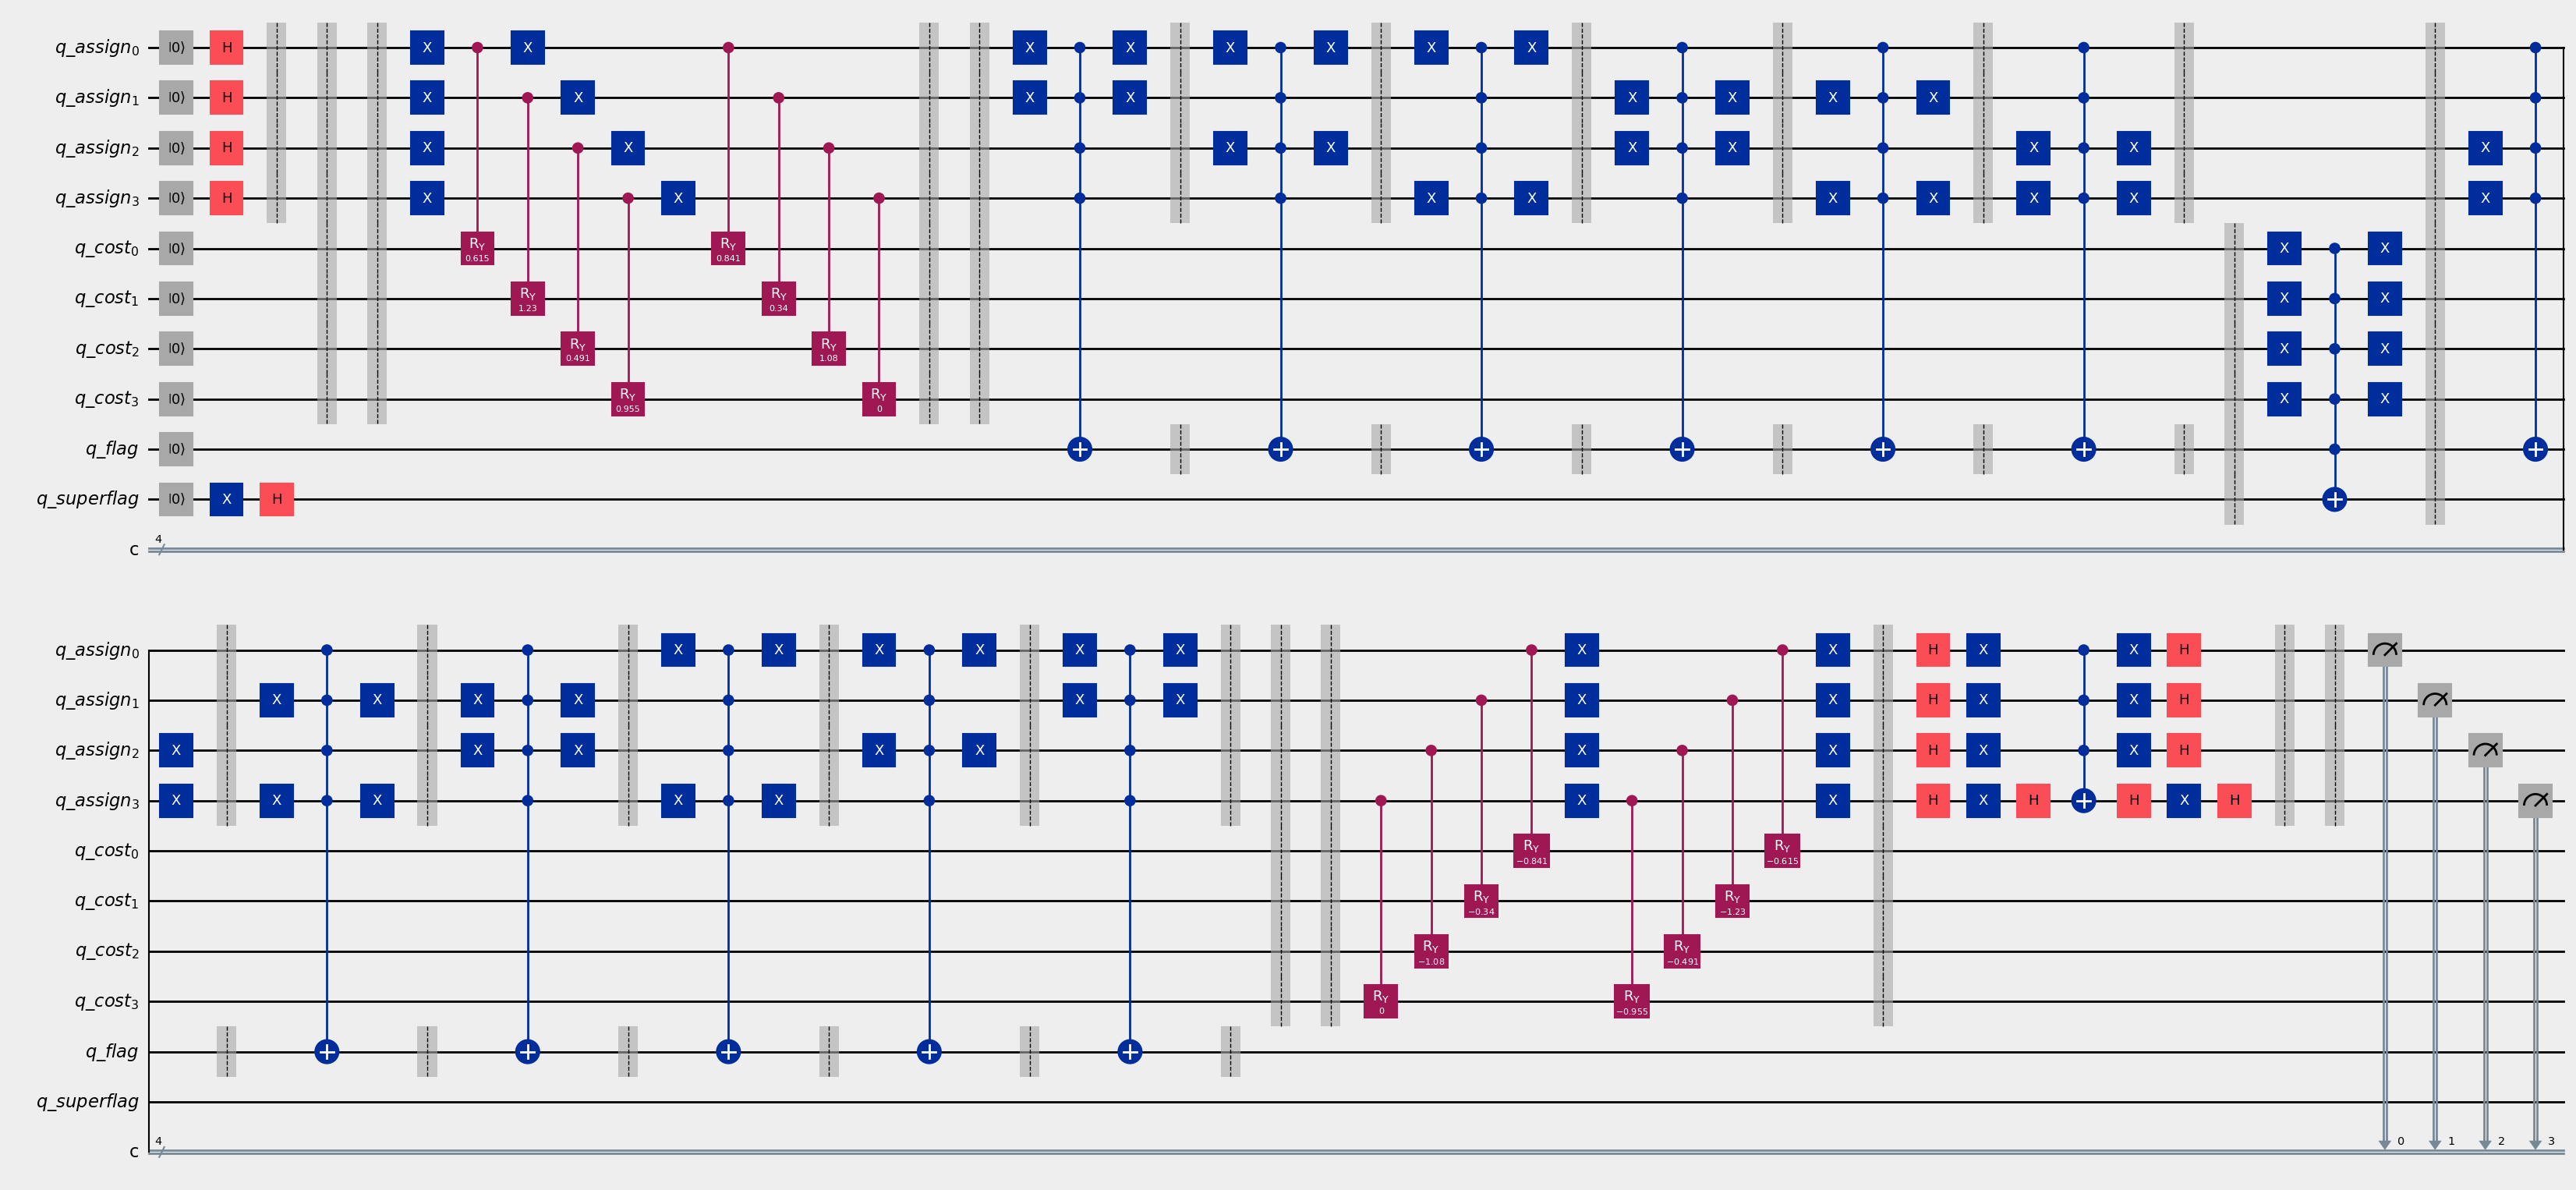

In [64]:
N = 4; M = 2
cost = np.array([[6.01, 3.97],
                 [1.10, 8.36],
                 [6.88, 2.21],
                 [2.85, 9.11]])

feasible_set = [
    [0,0,1,1],
    [0,1,0,1],
    [0,1,1,0],
    [1,0,0,1],
    [1,0,1,0],
    [1,1,0,0],
]

qc = amplify_amplitude(N, M, cost, feasible_set, alpha=0.5, iterations=1)

qc.draw(output='mpl',
        scale=1.0,
        fold=48,
        style={'backgroundcolor':'#EEEEEE'},
        plot_barriers=True)

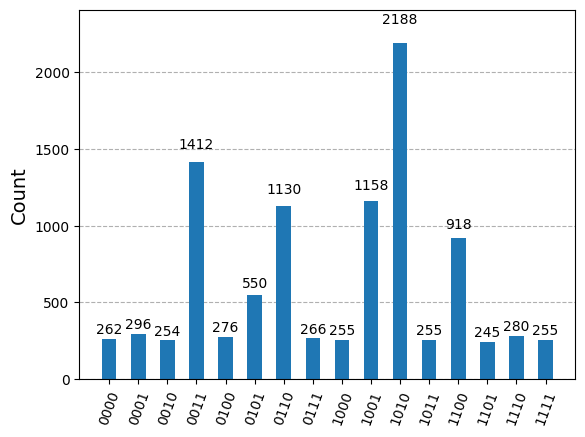

In [65]:
backend = Aer.get_backend('aer_simulator')
transpiled = transpile(qc, backend)
result = backend.run(transpiled, shots=10000).result()
counts = result.get_counts()
hist = plot_histogram(counts)
hist